<a href="https://colab.research.google.com/github/eylulyaltir/DSA210-Project/blob/main/dsa210plot3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

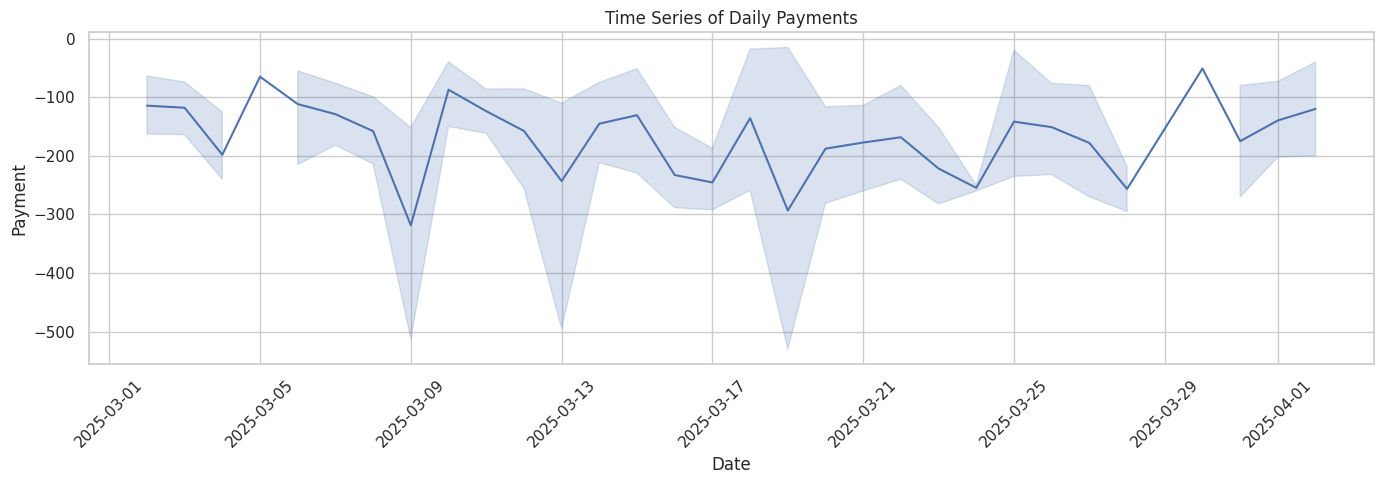

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Loading, cleaning and merging datasets
transactions_df = pd.read_csv("transactions.csv", sep=';')
weather_df = pd.read_excel("weatherdataset.xlsx")

transactions_df.columns = ['Date', 'Payment', 'Left_Budget', 'Category', 'Campus_Spendings']
transactions_df['Payment'] = transactions_df['Payment'].str.replace(' TL', '', regex=False).str.replace(',', '.').str.strip()
transactions_df['Payment'] = pd.to_numeric(transactions_df['Payment'], errors='coerce')
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'].str[:10], errors='coerce')

weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], errors='coerce')
weather_df = weather_df[['datetime', 'temp', 'humidity', 'feelslike', 'windspeed', 'conditions']]
weather_df.rename(columns={'datetime': 'Date'}, inplace=True)


merged_df = pd.merge(transactions_df, weather_df, on='Date', how='inner')


merged_df['temp_group'] = pd.cut(merged_df['temp'], bins=[0, 10, 17, 30], labels=['Cold', 'Mild', 'Warm'])
category_temp_group = merged_df.groupby(['temp_group', 'Category'], observed=True)['Payment'].mean().unstack()


# EDA Visualizations
sns.set(style="whitegrid")

# 1. Time Series Plot of Payments
plt.figure(figsize=(14, 5))
sns.lineplot(data=merged_df.sort_values('Date'), x='Date', y='Payment')
plt.title('Time Series of Daily Payments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



The time series plot shows the fluctuation of daily spending over a one-month period. There are noticeable spikes and dips, indicating that certain days involved significantly higher or lower payments. Despite the variability, no clear upward or downward trend is visible, suggesting that spending patterns remained relatively stable during the observed time frame.

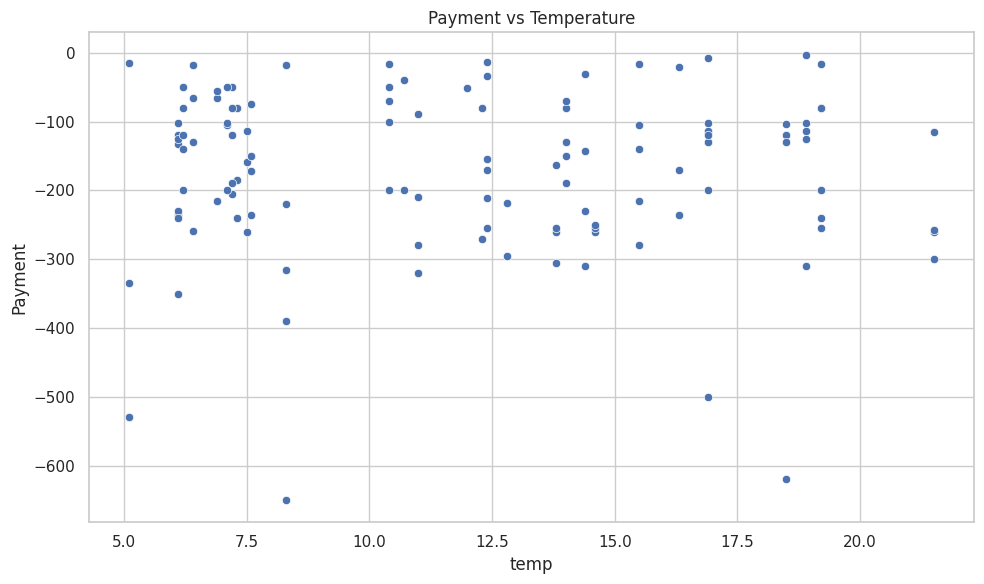

In [3]:
# 2. Scatter Plot: Payment vs Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='temp', y='Payment')
plt.title('Payment vs Temperature')
plt.tight_layout()
plt.show()



The scatter plot illustrates the relationship between daily temperature and spending amounts. The points appear widely dispersed without a clear trend, suggesting no strong correlation between temperature and payment behavior. This visual observation aligns with the ANOVA test, which also found no statistically significant difference in spending across temperature ranges.

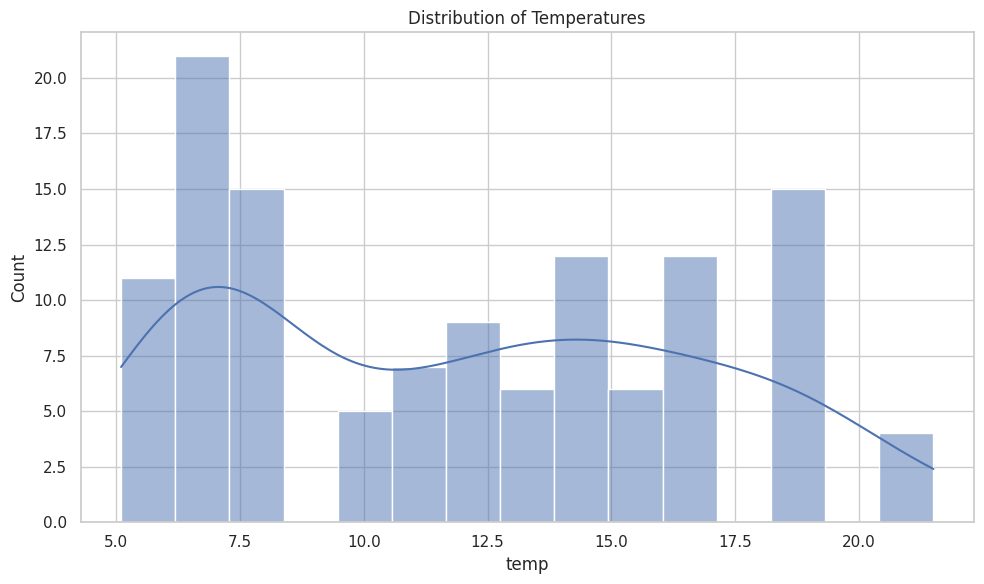

In [4]:
# 3. Histogram of Temperature
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['temp'], bins=15, kde=True)
plt.title('Distribution of Temperatures')
plt.tight_layout()
plt.show()



The histogram shows the distribution of temperatures recorded during the observation period. Most of the temperatures fall between 5°C and 10°C, indicating that the dataset is dominated by cooler weather. Warmer temperatures above 15°C occur less frequently, which may slightly limit the analysis of spending behavior in higher temperature conditions.

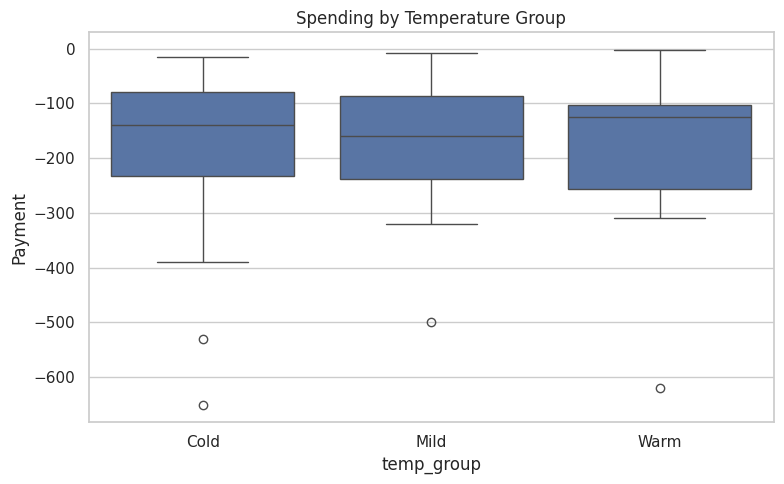

In [10]:
# 4. Boxplot: Spending by Temperature Group
merged_df['temp_group'] = pd.cut(merged_df['temp'], bins=[0, 10, 17, 30], labels=['Cold', 'Mild', 'Warm'])
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x='temp_group', y='Payment')
plt.title('Spending by Temperature Group')
plt.tight_layout()
plt.show()




The boxplot illustrates the distribution of spending across three temperature groups: Cold, Mild, and Warm. While the median spending appears relatively consistent, the spread is slightly narrower in warm conditions and wider in colder ones, suggesting more variability in spending during cold days. However, no dramatic differences are observed between groups, which supports the earlier ANOVA result indicating that temperature does not significantly affect spending behavior.



In [9]:
daily_spending = transactions_df.groupby('Date')['Payment'].sum().reset_index()

weather_for_merge = weather_df[['Date', 'conditions']]
merged_daily = pd.merge(daily_spending, weather_for_merge, on='Date', how='inner')

merged_daily['is_rain'] = merged_daily['conditions'].str.contains("Rain", case=False)

avg_daily_spending_by_rain = merged_daily.groupby('is_rain')['Payment'].mean()
print("Average Daily Spending by Rainy vs Non-Rainy Days:\n", avg_daily_spending_by_rain)

rainy_totals = merged_daily[merged_daily['is_rain']]['Payment']
non_rainy_totals = merged_daily[~merged_daily['is_rain']]['Payment']
t_stat, p_value = ttest_ind(rainy_totals, non_rainy_totals, equal_var=False)
print(f"Daily Total Spending T-test:\nt-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

Average Daily Spending by Rainy vs Non-Rainy Days:
 is_rain
False   -717.563333
True    -607.515385
Name: Payment, dtype: float64
Daily Total Spending T-test:
t-statistic: 0.9326, p-value: 0.3587


In [14]:
from scipy.stats import f_oneway

# --- ANOVA Test: Cold vs Mild vs Warm ---
cold = merged_df[merged_df['temp_group'] == 'Cold']['Payment']
mild = merged_df[merged_df['temp_group'] == 'Mild']['Payment']
warm = merged_df[merged_df['temp_group'] == 'Warm']['Payment']

f_stat, p_val = f_oneway(cold.dropna(), mild.dropna(), warm.dropna())
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.4f}")

# --- Output from previously calculated T-Test ---
print("\n Average Daily Spending:")
print(merged_daily.groupby('is_rain')['Payment'].mean())

print(f"\nT-Test (Daily Totals) Results:\nt-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")


ANOVA F-statistic: 0.159, p-value: 0.8531

 Average Daily Spending:
is_rain
False   -717.563333
True    -607.515385
Name: Payment, dtype: float64

T-Test (Daily Totals) Results:
t-statistic: 0.9326, p-value: 0.3587


The statistical analysis revealed that weather conditions, specifically temperature and rain, did not have a significant impact on my personal spending behavior. According to the ANOVA test conducted on three temperature groups (Cold, Mild, and Warm), the resulting F-statistic was 0.159 with a p-value of 0.8531. Since the p-value is well above the 0.05 significance threshold, we fail to reject the null hypothesis and conclude that there is no meaningful difference in average spending across temperature ranges. Similarly, a t-test comparing average daily spending on rainy versus non-rainy days yielded a t-statistic of 0.9326 and a p-value of 0.3587. Although the average spending was slightly lower on rainy days (-607.52 TL) compared to non-rainy days (-717.56 TL), this difference is not statistically significant. These results suggest that, at least within this dataset, my spending habits appear to be relatively unaffected by short-term weather changes.


In [13]:
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
merged_df['is_rain'] = merged_df['conditions'].str.contains("Rain", case=False)
contingency = pd.crosstab(merged_df['Category'], merged_df['is_rain'])
chi2, chi_p, dof, expected = chi2_contingency(contingency)
print("\nChi-Square Test (Category × Rain):")
print(f"Chi2 Statistic = {chi2:.4f}, Degrees of Freedom = {dof}, p-value = {chi_p:.4f}")



Chi-Square Test (Category × Rain):
Chi2 Statistic = 7.3760, Degrees of Freedom = 7, p-value = 0.3908


The chi-square test examined the relationship between spending categories and whether it was a rainy day. The resulting p-value of 0.3908 is well above the 0.05 threshold, indicating no statistically significant association. This suggests that the distribution of spending across categories does not meaningfully change depending on rain conditions.

<Figure size 1400x700 with 0 Axes>

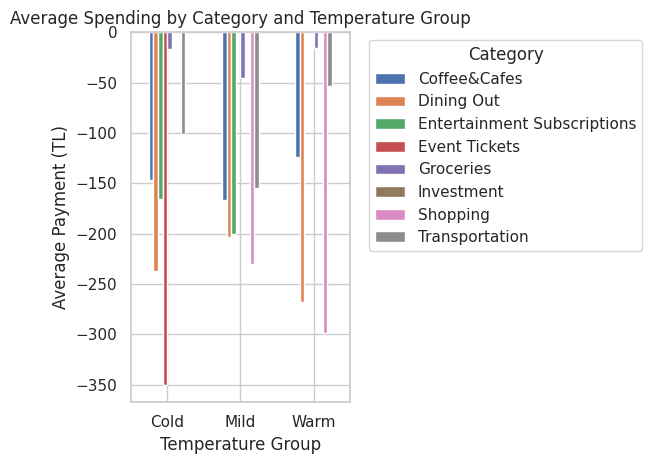

Category: Coffee&Cafes | F-statistic: 0.5905, p-value: 0.5592
Category: Dining Out | F-statistic: 0.9076, p-value: 0.4108
Category: Transportation | F-statistic: 2.7510, p-value: 0.1074


In [4]:
from scipy.stats import f_oneway
plt.figure(figsize=(14, 7))
category_temp_group.plot(kind='bar')
plt.title('Average Spending by Category and Temperature Group')
plt.ylabel('Average Payment (TL)')
plt.xlabel('Temperature Group')
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ANOVA Test: For Each Category Across Temperature Groups
category_anova_results = {}

for category in merged_df['Category'].unique():
    subset = merged_df[merged_df['Category'] == category]
    cold = subset[subset['temp_group'] == 'Cold']['Payment']
    mild = subset[subset['temp_group'] == 'Mild']['Payment']
    warm = subset[subset['temp_group'] == 'Warm']['Payment']

    if len(cold.dropna()) > 1 and len(mild.dropna()) > 1 and len(warm.dropna()) > 1:
        f_stat, p_val = f_oneway(cold.dropna(), mild.dropna(), warm.dropna())
        category_anova_results[category] = (f_stat, p_val)

for category, (f_stat, p_val) in category_anova_results.items():
    print(f"Category: {category} | F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")

The ANOVA tests explored whether spending in different categories varied significantly across temperature groups. For "Coffee&Cafes" and "Dining Out," the p-values were 0.5592 and 0.4108 respectively, indicating no significant difference in spending based on temperature. Although "Transportation" showed a visible trend with a lower p-value of 0.1074, it was still not statistically significant, suggesting that temperature does not have a strong proven effect on category-specific spending habits.